In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')

X_train = train_data.drop(columns=['median_house_value'])
y_train = train_data['median_house_value']

X_val = val_data.drop(columns=['median_house_value'])
y_val = val_data['median_house_value']

X_test = test_data.drop(columns=['median_house_value'])
y_test = test_data['median_house_value']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest - MAE: {mae_rf}, MSE: {mse_rf}, R²: {r2_rf}')


Random Forest - MAE: 32799.82370155039, MSE: 2568531107.468108, R²: 0.8029312226516143


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Định nghĩa không gian siêu tham số
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Tìm kiếm siêu tham số trên tập train và đánh giá trên tập validation
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Số lần thử
    scoring='neg_mean_absolute_error',
    cv=5,  # Cross-validation
    verbose=2,
    random_state=42,
    n_jobs=1
)

# Huấn luyện mô hình với RandomizedSearchCV
rf_search.fit(X_train, y_train)

# In kết quả tốt nhất từ RandomizedSearchCV
print(f"Best parameters found: {rf_search.best_params_}")

# Dự đoán trên tập test
y_test_pred = rf_search.best_estimator_.predict(X_test)

# Đánh giá mô hình trên tập test
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'Random Forest - MAE: {test_mae}, MSE: {test_mse}, R²: {test_r2}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   6.1s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   6.4s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   6.8s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   7.2s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   6.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=

c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
80 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\dungp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.p

Best parameters found: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Random Forest - MAE: 31861.097920572098, MSE: 2387084057.6063647, R²: 0.8168526223830634


In [3]:
import pickle

with open('optimized_random_forest.pkl', 'wb') as rf_file:
    pickle.dump(rf_search, rf_file)


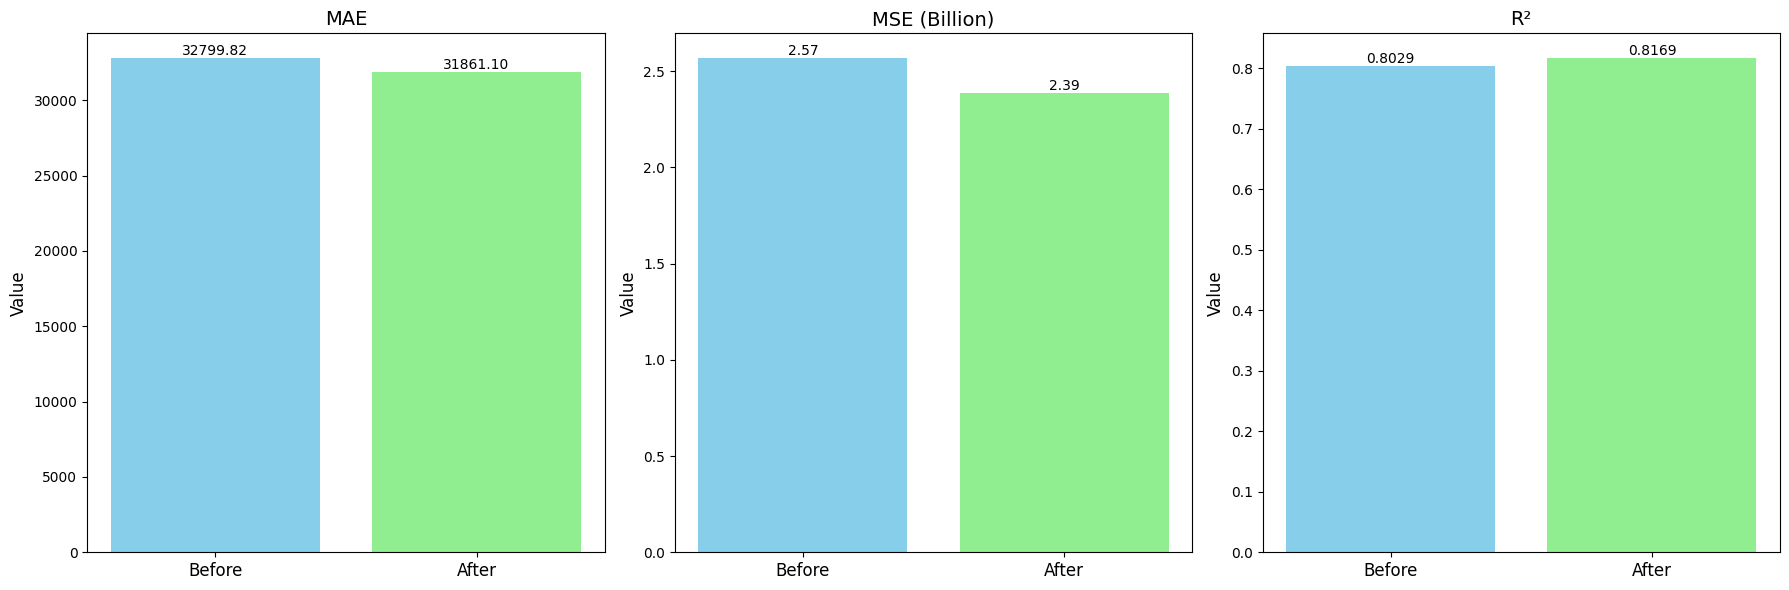

In [7]:
import matplotlib.pyplot as plt

# Data for each metric
metrics_individual = ['MAE', 'MSE (Billion)', 'R²']
before_values = [mae_rf, mse_rf/1e9, r2_rf]
after_values = [test_mae, test_mse/1e9, test_r2]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each metric and create individual plots
for i, ax in enumerate(axes):
    ax.bar(['Before', 'After'], [before_values[i], after_values[i]], color=['skyblue', 'lightgreen'])
    ax.set_title(metrics_individual[i], fontsize=14)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Before', 'After'], fontsize=12)
    
    # Annotate bars
    for j, value in enumerate([before_values[i], after_values[i]]):
        ax.text(j, value, f'{value:.2f}' if i < 2 else f'{value:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
